In [2]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import logging
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.utils.data as Data


In [7]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# T = np.arctan2(y,x)
torch_dataset = Data.TensorDataset(x, y)


In [4]:
x, y = torch_dataset[0]
x.shape

torch.Size([1])

In [5]:
data_set

NameError: name 'data_set' is not defined

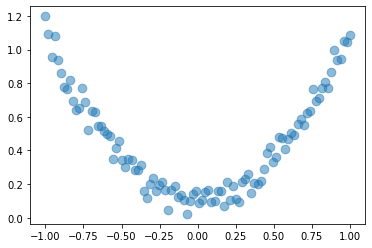

In [8]:
# plt.ion()   # something about plotting
plt.scatter(x,y,s=75,alpha=0.5)
# plt.ioff()
plt.show()

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
#         self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
#         x = self.predict(x)             # linear output
        return x

In [ ]:
model = Net(n_feature=1, n_hidden=10, n_output=1)
for i in range(len(list(model.parameters()))):  # 查看模型参数
    print('params: %d' % (i + 1), list(model.parameters())[i].size())

In [ ]:
BOX = DataLoader(torch_dataset, batch_size= 1, shuffle=True)

In [ ]:
x, y = next(iter(BOX))

In [ ]:
x.view(-1,1)

In [ ]:
class PytorchLightningModel(pl.LightningModule): # 這邊一定要繼承pl.LightningModule
    def __init__(self): # 初始化時可以將基本設定傳入。
        super().__init__()
        self.ln1 = nn.Linear(1, 10)
        self.ln2 = nn.Linear(10, 1)
        self.batch_size = 1
    def prepare_data(self): # 此方法會在初始化後優先執行。 所以可以在此方法中先將會用到的資料都讀取進來.
        self.train_set = torch_dataset # read_data是自定義的讀取資料Method. 可以按照自己需求調整
        self.test_set = torch_dataset
        self.val_set = torch_dataset
        logging.info("===== Data is ready... =====")

    def configure_optimizer(self): # 自動訓練時會呼叫此方法來獲取Optimizer.
        return Adam(self.parameters(), lr=1e-3) # 這邊注意要調整的參數是`self.parameters()`

    # 以下三個方法則是設定進行訓練及驗證時所要使用的Data Loader格式。
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size= self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size= self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size= self.batch_size, shuffle=True)

    def forward(self, x): # 定義模型在forward propagation時如何進行.
        output = F.relu(self.ln1(x))
#         output = output.view(-1,10)
        output = self.ln2(output)
        return output

    def training_step(self, batch, batch_idx): # 定義訓練過程的Step要如何進行
        x, y = batch # 從self.train_dataloader()的Data Loader取一個batch出來。
#         x.view(-1,1)
        output = self.forward(x)
#         criterion = nn.CrossEntropyLoss()
        criterion = torch.nn.MSELoss()
        loss = criterion(output, y)
        logs = {'loss': loss}
        return {'loss':loss, 'log':logs}

    def validation_step(self, batch, batch_idx): # 定義Validation如何進行，以這邊為例就再加上了計算Acc.
        x, y = batch # 從self.train_dataloader()的Data Loader取一個batch出來。
#         x.view(-1,1)
        logits = self.forward(x)
#         loss = F.cross_entropy(logits, y)]
        loss = F.mse_loss(logits,y)

        # acc
#         a, y_hat = torch.max(logits, dim=1)
#         val_acc = accuracy_score(y_hat.cpu(), y.cpu())
#         val_acc = torch.tensor(val_acc)

        return {'val_loss': loss}#, 'val_acc': val_acc}

    def validation_epoch_end(self, outputs): # 在Validation的一個Epoch結束後，計算平均的Loss及Acc.
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#         avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {"val_mse_loss": avg_loss}
        progress_bar_metrics = tensorboard_logs
#         tensorboard_logs = {'val_loss': avg_loss, 'avg_val_acc': avg_val_acc}
        return {'avg_val_loss': avg_loss, 'progress_bar': progress_bar_metrics}

    def test_step(self, batch, batch_idx): #定義 Test 階段
        x, y = batch # 從self.train_dataloader()的Data Loader取一個batch出來。
#         x.view(-1,1)
        logits = self.forward(x)
#         loss = F.cross_entropy(logits, y)
        loss = F.mse_loss(logits,y)
        # acc
#         a, y_hat = torch.max(logits, dim=1)
#         val_acc = accuracy_score(y_hat.cpu(), y.cpu())
#         val_acc = torch.tensor(val_acc)

        return {'test_loss': loss}

In [ ]:
model = PytorchLightningModel() # 自行封裝成Pytorch Lightning的模型

# Trainer 有不同的參數可以調整訓練時的行為
# trainer = pl.Trainer() # 使用CPU
trainer = pl.Trainer(gpus=1) # 使用GPU
trainer = pl.Trainer(fast_dev_run=True) #訓練時，使用單一個batch作為ㄧ個Epoch，目的是快速的確認當前的模型設置有無結構上的問題(快速地跑完Train -> Validation -> Test)。
for i in range(100):
    trainer.fit(model) # 呼叫.fit() 就會自動進行Model的training step及validation step.
    

In [ ]:
model

In [ ]:
# plot and show learning process
plt.cla()
plt.scatter(x.data.numpy(), y.data.numpy())
prediction = model(x)
plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
# plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
plt.pause(0.1)

In [16]:
g = torch.tensor([[[1., 2., 3., 4., 5., 6.],
                 [1., 2., 3., 4., 5., 6.],
                 [1., 2., 3., 4., 5., 6.],
                 [1., 2., 3., 4., 5., 6.]]])#,requires_grad=True)
p = torch.tensor([[[3., 4., 1., 1., 1., 1.],
                 [3., 4., 1., 1., 1., 1.],
                 [3., 4., 1., 1., 1., 1.],
                 [3., 4., 1., 1., 1., 1.]]])#,requires_grad=True)
# g = g*5
print(g.requires_grad,g.grad,g.grad_fn,g.shape)

False None None torch.Size([1, 4, 6])


In [67]:
g_ = g.permute(0,2,1)
p_ = p.permute(0,2,1)
print(g_)
print(p_)

tensor([[[1., 1., 1., 1.],
         [2., 2., 2., 2.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         [6., 6., 6., 6.]]])
tensor([[[3., 3., 3., 3.],
         [4., 4., 4., 4.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])


In [46]:
unit_q = torch.cat((torch.ones(1,6,1),torch.zeros(1,6,3)),dim=2)
result = g_ - unit_q
result

tensor([[[0., 1., 1., 1.],
         [1., 2., 2., 2.],
         [2., 3., 3., 3.],
         [3., 4., 4., 4.],
         [4., 5., 5., 5.],
         [5., 6., 6., 6.]]])

In [59]:
pre_norm = torch.index_select(result, dim=2, index=torch.tensor([1,2,3]), out=None)
torch.norm(pre_norm,p=2,dim=2,out=None,keepdim=True)

tensor([[[ 1.7321],
         [ 3.4641],
         [ 5.1962],
         [ 6.9282],
         [ 8.6603],
         [10.3923]]])

In [93]:
pred = torch.tensor([[[1.],
                     [1.],
                     [1.],
                     [1.],
                     [1.],
                     [1.]]])
label = torch.tensor([[[3.],
                     [4.],
                     [5.],
                     [6.],
                     [7.],
                     [8.]]])

A = torch.pow((pred - label), 2)
loss , indice =torch.topk(A, 3, dim=1, largest=True, sorted=True, out=None)
print(loss)
# loss.sum(dim=1)
torch.mean(loss)

tensor([[[49.],
         [36.],
         [25.]]])


tensor(36.6667)